In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
image = cv.imread("images/attachment1.png")

In [2]:
def plot_comparison(original, filtered, filter_name, original_name = "original"):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title(original_name)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

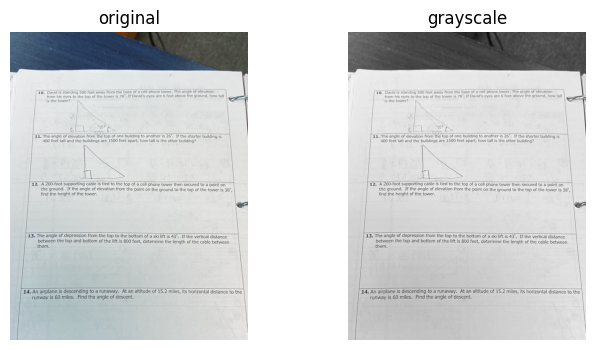

In [3]:
grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# plot the original and the result of grayscale
plot_comparison(image, grayscale, "grayscale")

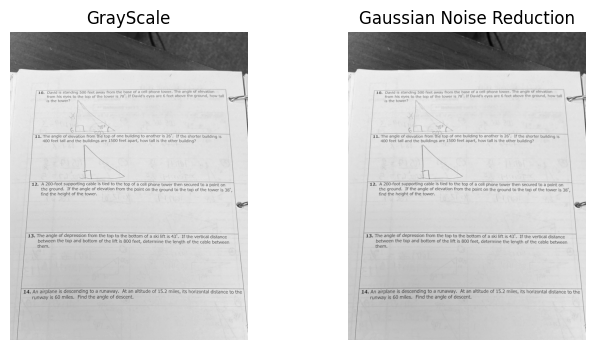

In [4]:
# Apply Gaussian Noise reduction
denoised = cv.GaussianBlur(grayscale, (5, 5), 0)

plot_comparison(grayscale, denoised, "Gaussian Noise Reduction", "GrayScale")

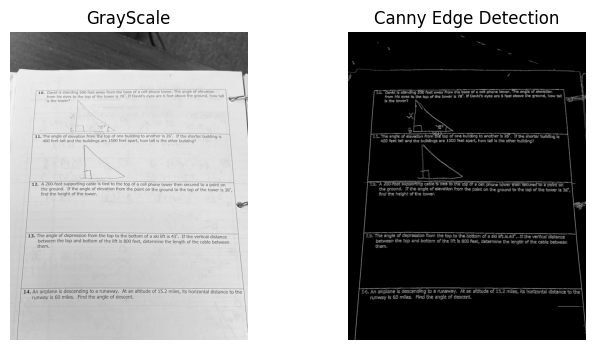

In [5]:
edged_blurred = cv.Canny(denoised, 75, 200)
edged_normal = cv.Canny(grayscale, 75, 200)
edged = cv.bitwise_or(edged_blurred, edged_normal)


plot_comparison(grayscale, edged, "Canny Edge Detection", "GrayScale")

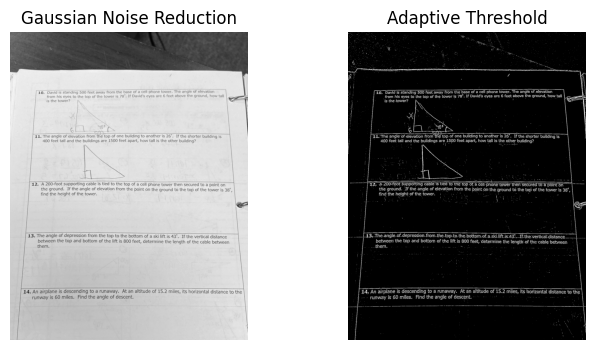

In [6]:
thresholded = cv.adaptiveThreshold(denoised, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 5, 2)

plot_comparison(denoised, thresholded, "Adaptive Threshold", "Gaussian Noise Reduction")

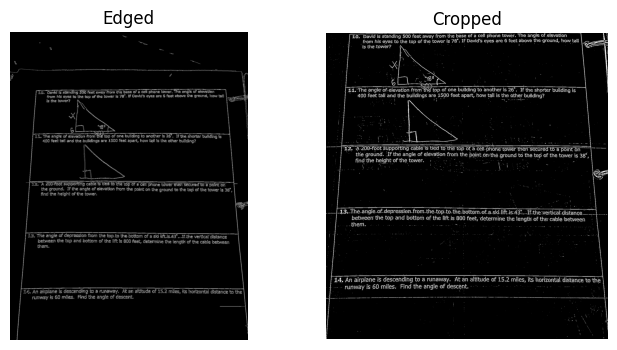

In [7]:
contours, _ = cv.findContours(edged.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
docCnt = None
if contours:
    docCnt = sorted(contours, key=cv.contourArea, reverse=True)[0]
x, y, w, h = cv.boundingRect(docCnt)
cropped = thresholded[y:y+h, x:x+w]

plot_comparison(edged, cropped, "Cropped", "Edged")

In [8]:
import math
def rotate(
        image: np.ndarray, angle: float, background
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

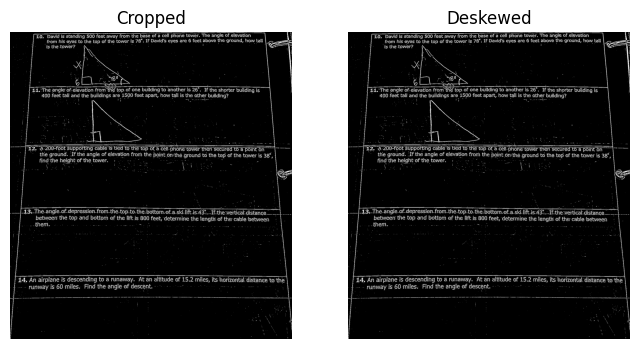

In [9]:
from deskew import determine_skew

angle = determine_skew(cropped)
deskewed = rotate(cropped, angle, (0, 0, 0))

plot_comparison(cropped, deskewed, "Deskewed", "Cropped")

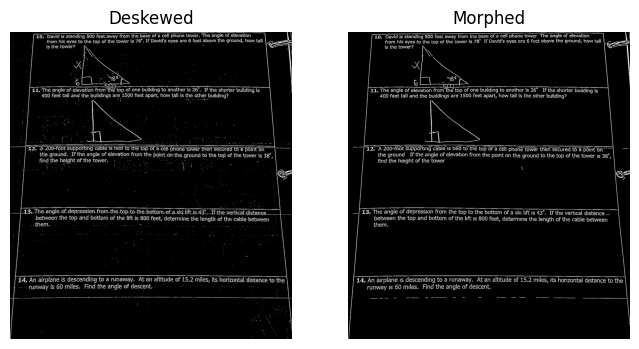

In [10]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))
# otherKernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2, 2))

# opened = cv.morphologyEx(deskewed, cv.MORPH_ERODE, otherKernel)
morphed = cv.morphologyEx(deskewed, cv.MORPH_OPEN, kernel)
morphed = cv.morphologyEx(morphed, cv.MORPH_CLOSE, kernel)

# find contours - write black over all small contours
morphedFinal = morphed.copy()
cntrs = cv.findContours(morphed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]
for c in cntrs:
    area = cv.contourArea(c)
    if area < 15:
        cv.drawContours(morphedFinal,[c],0,(0,0,0),-1)

plot_comparison(deskewed, morphedFinal, "Morphed", "Deskewed")

True

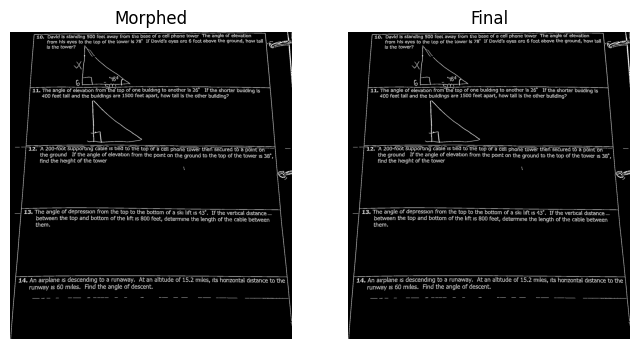

In [11]:
# Sharpen all edges
sharpened = cv.filter2D(morphedFinal, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))

plot_comparison(morphedFinal, sharpened, "Final", "Morphed")

cv.imwrite("images/attachment1_processed.png", morphedFinal)

In [12]:
import pytesseract

# Read the image
image = cv.imread("images/attachment1_processed.png")

# read the original image
original = cv.imread("images/attachment1.png")

# Convert the image to string
textPreprocessed = pytesseract.image_to_string(image)

# Convert the original image to string
textOriginal = pytesseract.image_to_string(original)

with open("images/attachment1_processed.txt", "w") as f:
    f.write(textPreprocessed)

with open("images/attachment1.txt", "w") as f:
    f.write(textOriginal)